# - Import Library

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

--------------------------
# - Unitility Function

In [237]:
def load_data(load_application, load_bureau):
    """
    Load data from CSV files into pandas DataFrames.
    """
    path=f'..//data//raw//'
    global application_train, application_test, bureau, bureau_balance
    
    if load_application:
        print('Loading application_train.csv')
        application_train = pd.read_csv(path + 'application_train.csv')
        print('Loading application_test.csv')
        application_test = pd.read_csv(path + 'application_test.csv')
    
    if load_bureau:
        print('Loading bureau.csv')
        bureau = pd.read_csv(path + 'bureau.csv')
        print('Loading bureau_balance.csv')
        bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
        
    print('Done loading data into dataframes')
    
def convert_to_categorical(df, numerical_columns, categorical_columns):
    """
    Some numerical columns will actually be changed to categorical columns
    because they are categorical in nature, but they are stored as numerical columns.
    """
    numercial_to_categorical = []

    # Columns start with CNT_
    cnt_columns = [col for col in numerical_columns if col.startswith('CNT_')]
    numercial_to_categorical.extend(cnt_columns)
    
    # Columns with FLAG_
    flag_columns = [col for col in numerical_columns if col.startswith('FLAG_')]
    numercial_to_categorical.extend(flag_columns)
    
    # Columns with REGION_RATING_
    region_columns = [col for col in numerical_columns if col.startswith('REGION_RATING_')]
    numercial_to_categorical.extend(region_columns)
    
    # Columns with AMT_REQ_CREDIT_
    amt_columns = [col for col in numerical_columns if col.startswith('AMT_REQ_CREDIT_')]
    numercial_to_categorical.extend(amt_columns)
    
    # Columns with REG_
    reg_columns = [col for col in numerical_columns if col.startswith('REG_')]
    numercial_to_categorical.extend(reg_columns)
    
    # Columns with LIVE_
    live_columns = [col for col in numerical_columns if col.startswith('LIVE_')]
    numercial_to_categorical.extend(live_columns)

    if numercial_to_categorical:
        print(f'Converting {len(numercial_to_categorical)} numerical columns to categorical columns')
        for col in numercial_to_categorical:
            df[col] = df[col].astype('object')
            numerical_columns.remove(col)
            categorical_columns.append(col)
    else:
        print('No numerical columns to convert to categorical columns')
        
    return numerical_columns, categorical_columns

In [238]:
def plot_object_col_num(data, title, col, tight_layout=True, 
                        figsize= (10, 5), rotation=0):
    """
    Plot the count of unique values in a categorical column.
    """
    plt.figure(figsize=figsize)
    sns.countplot(data[col], order=data[col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=rotation)
    if tight_layout:
        plt.tight_layout()
    plt.show()

def plot_object_col_percent(data, title, col, tight_layout=True, 
                            figsize=(10, 5), rotation=0, palette='Set2'):
    """
    Plot the percentage of unique values in a categorical column.
    """
    plt.figure(figsize=figsize)
    value_counts = data[col].value_counts(normalize=True)
    sns.barplot(x=value_counts.values * 100, y=value_counts.index, palette=palette)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=rotation, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Percent', fontsize=10)
    plt.ylabel(col, fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    if tight_layout:
        plt.tight_layout()
    plt.show()

In [239]:
def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [240]:
def plot_categorical_variables_pie(data, column_name, 
                                   plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()
    
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), 
                                   percentage_display = True, plot_defaulter = True, 
                                   rotation = 0, horizontal_adjust = 0, 
                                   fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set_theme(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [241]:
def print_percentiles(data, column_name, percentiles = None):
    """
    Print the percentiles of a given column in the DataFrame.
    """
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("*"*100)
    
def plot_continuous_variables(data, column_name, 
                              plot_types=['CDF', 'distplot', 'violin', 'box'], 
                              log_scale=False):
    
    data_to_plot = data[[column_name, 'TARGET']].dropna()
    
    for ele in plot_types:
        plt.figure(figsize=(10, 5))
        
        if ele == 'CDF':
            percentile_values_0 = data_to_plot[data_to_plot['TARGET'] == 0][[column_name]].sort_values(by=column_name)
            percentile_values_1 = data_to_plot[data_to_plot['TARGET'] == 1][[column_name]].sort_values(by=column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color='red', label='Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color='black', label='Defaulters')
            plt.xlabel(column_name, fontsize=14, fontweight='bold')
            plt.ylabel('Probability', fontsize=14, fontweight='bold')
            plt.title(f'CDF of {column_name}', fontsize=16, fontweight='bold')
            plt.legend(fontsize='medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} - (log-scale)', fontsize=14, fontweight='bold')
        
        if ele == 'distplot':
            sns.histplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(), kde=True, label='Non-Defaulters', color='red', stat="density")
            sns.histplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(), kde=True, label='Defaulters', color='black', stat="density")
            plt.xlabel(column_name, fontsize=14, fontweight='bold')
            plt.ylabel('Probability Density', fontsize=14, fontweight='bold')
            plt.legend(fontsize='medium')
            plt.title(f'Dist-Plot of {column_name}', fontsize=16, fontweight='bold')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)', fontsize=14, fontweight='bold')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot, palette='Set2')
            plt.title(f'Violin-Plot of {column_name}', fontsize=16, fontweight='bold')
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)', fontsize=14, fontweight='bold')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot, palette='Set2')
            plt.title(f'Box-Plot of {column_name}', fontsize=16, fontweight='bold')
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)', fontsize=14, fontweight='bold')

        sns.despine(left=True, bottom=True)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

In [242]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [243]:
def plot_phik_matrix(data, categorical_columns, figsize=(20, 20), 
                     mask_upper=True, tight_layout=True, linewidth=0.1, 
                     fontsize=10, cmap='coolwarm', show_target_top_corr=True, target_top_columns=10):
    
    data_for_phik = data[categorical_columns].astype('object')
    # Add TARGET column if it exists in the original data
    if 'TARGET' in data.columns:
        data_for_phik['TARGET'] = data['TARGET']
    phik_matrix = data_for_phik.phik_matrix()

    print('*' * 100)

    # Tạo mask
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)

    plt.figure(figsize=figsize, tight_layout=tight_layout)
    sns.heatmap(phik_matrix, annot=False, mask=mask_array, linewidth=linewidth, cmap=cmap)
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")

   # Khung
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color('black')  # Chỉnh màu khung nếu cần

    plt.show()
    print("*" * 100)

    if show_target_top_corr:
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name': phik_matrix.TARGET.index[1:], 'Phik-Correlation': phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by='Phik-Correlation', ascending=False)
        display(phik_df.head(target_top_columns))
        print("*" * 100)

In [244]:
def nan_df_create(data):
    """
    Create a dataframe with the percentage of missing values in each column of the input dataframe. 
    """
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})

    #sorting the dataframe by decreasing order
    df = df.sort_values(by = 'percent', ascending = False)
    return df

def plot_nan(df_nan, title, figsize=(20, 8),
             tight_layout=True, grid=True, rotation=90):
    """ 
    Plot the percentage of missing values in each column of the dataframe. 
    """
    if df_nan[df_nan['percent'] != 0].shape[0] != 0:
        print(f"{df_nan[df_nan['percent'] != 0].shape[0]} columns have missing values")
        plt.figure(figsize=figsize, tight_layout=tight_layout)
        sns.barplot(x='column', y='percent', data=df_nan[df_nan['percent'] != 0], palette='tab10', edgecolor=None)
        plt.title(f'Percentage of missing values in each column of {title}', fontsize=16, fontweight='bold')
        plt.xlabel('Columns', fontsize=10, fontweight='bold')
        plt.ylabel('Percentage of missing values', fontsize=10, fontweight='bold')
        plt.xticks(rotation=rotation, fontsize=10)
        plt.yticks(fontsize=10)
        # plt.grid(grid, axis='y', linestyle='--', alpha=0.7)  # Chỉ hiển thị lưới ngang
        sns.despine(left=True, bottom=True)

        # Thêm khung xung quanh biểu đồ
        plt.gca().spines['top'].set_visible(True)
        plt.gca().spines['right'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)

        plt.show()
    else:
        print('No missing values in the dataframe')

In [245]:
def detect_outliers(df, column, threshold=1.5, plot=True, figsize=(12, 6)):
    """
    Detect outliers in a specified column using the IQR method.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    column : str
        The column name to check for outliers
    threshold : float, default=1.5
        The threshold multiplier for IQR to identify outliers
    plot : bool, default=True
        Whether to plot the distribution with outliers highlighted
    figsize : tuple, default=(12, 6)
        Figure size for the plot
        
    Returns:
    --------
    pandas.Series
        Boolean mask where True indicates an outlier
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Identify outliers
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    if plot:
        plt.figure(figsize=figsize)
        
        # Create subplot for boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
        plt.axhline(y=upper_bound, color='r', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
        plt.legend()
        
        # Create subplot for histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[column], kde=True)
        plt.axvline(x=lower_bound, color='r', linestyle='--')
        plt.axvline(x=upper_bound, color='r', linestyle='--')
        plt.title(f'Distribution of {column} with Outlier Boundaries')
        
        plt.tight_layout()
        plt.show()
    
    print(f"Number of outliers detected: {outliers.sum()}")
    print(f"Percentage of outliers: {100 * outliers.sum() / len(df):.2f}%")
    
    return outliers

In [246]:
def check_duplicates(df, subset=None, keep=False, plot=True, figsize=(12, 6)):
    """
    Comprehensive function to check for duplicate values in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to check for duplicates
    subset : list or None, default=None
        Column names to consider for identifying duplicates.
        If None, use all columns
    keep : bool or str, default=False
        - False: Mark all duplicates as True
        - 'first': Mark all duplicates except first occurrence as True
        - 'last': Mark all duplicates except last occurrence as True
    plot : bool, default=True
        Whether to plot visualizations of duplicate data
    figsize : tuple, default=(12, 6)
        Figure size for the plots
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'duplicate_mask': Boolean mask where True indicates duplicates
        - 'duplicate_df': DataFrame with only duplicate rows
        - 'unique_df': DataFrame with duplicates removed
        - 'stats': Dictionary with statistics about duplicates
    """
    
    # Find duplicates
    duplicate_mask = df.duplicated(subset=subset, keep=keep)
    duplicate_count = duplicate_mask.sum()
    
    # Count duplicates by frequency
    if subset is None:
        col_list = df.columns.tolist()
    else:
        col_list = subset if isinstance(subset, list) else [subset]
    
    # Get duplicated rows
    duplicate_df = df[duplicate_mask].copy()
    
    # Get unique rows (with duplicates removed)
    unique_df = df.drop_duplicates(subset=subset, keep='first' if keep in [False, 'last'] else keep)
    
    # Calculate frequency of each duplicated combination
    if duplicate_count > 0:
        dup_counts = df.groupby(col_list).size().reset_index(name='frequency')
        dup_counts = dup_counts[dup_counts['frequency'] > 1].sort_values('frequency', ascending=False)
    else:
        dup_counts = pd.DataFrame(columns=[*col_list, 'frequency'])
    
    # Compile statistics
    stats = {
        'total_rows': len(df),
        'duplicate_rows': duplicate_count,
        'unique_rows': len(unique_df),
        'duplicate_percentage': (duplicate_count / len(df) * 100) if len(df) > 0 else 0,
        'duplicate_combinations': len(dup_counts),
        'most_common_duplicate': dup_counts.iloc[0].to_dict() if len(dup_counts) > 0 else None,
    }
    
    # Print summary
    print(f"Total rows: {stats['total_rows']}")
    print(f"Duplicate rows: {stats['duplicate_rows']} ({stats['duplicate_percentage']:.2f}%)")
    print(f"Unique combinations: {len(unique_df)}")
    print(f"Number of duplicated combinations: {stats['duplicate_combinations']}")
    
    if duplicate_count > 0:
        print("\nTop 5 most duplicated combinations:")
        print(dup_counts.head(5))
    
    # Visualize duplicates
    if plot and duplicate_count > 0:
        plt.figure(figsize=figsize)
        
        # Plot 1: Pie chart of duplicates vs unique
        plt.subplot(1, 2, 1)
        plt.pie(
            [len(df) - duplicate_count, duplicate_count],
            labels=['Unique', 'Duplicates'],
            autopct='%1.1f%%',
            startangle=90,
            colors=['lightblue', 'salmon']
        )
        plt.title('Proportion of Duplicate Rows')
        
        # Plot 2: Top duplicated combinations
        plt.subplot(1, 2, 2)
        top_n = min(10, len(dup_counts))
        if top_n > 0:
            sns.barplot(
                x='frequency',
                y=dup_counts.index[:top_n] if subset is None else range(top_n),
                data=dup_counts.iloc[:top_n],
                palette='viridis'
            )
            plt.title(f'Top {top_n} Most Frequent Duplicates')
            plt.xlabel('Frequency')
            plt.ylabel('Duplicate Combination Index')
        else:
            plt.text(0.5, 0.5, "No duplicates found", ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'duplicate_mask': duplicate_mask,
        'duplicate_df': duplicate_df,
        'unique_df': unique_df,
        'stats': stats,
        'dup_counts': dup_counts
    }

In [247]:
load_data(load_application=True, load_bureau=True)

print("Merging TARGET with bureau Table")
bureau = application_train[['SK_ID_CURR', 'TARGET']].merge(bureau, on = 'SK_ID_CURR', how = 'left')
print("Merging bureau_balance with bureau Table")

# Drop the SK_ID_CURR that exist in application_test in bureau and bureau_balance
bureau = bureau[~bureau['SK_ID_CURR'].isin(application_test['SK_ID_CURR'])]
bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(bureau['SK_ID_BUREAU'])]

Loading application_train.csv
Loading application_test.csv
Loading bureau.csv
Loading bureau_balance.csv
Done loading data into dataframes
Merging TARGET with bureau Table
Merging bureau_balance with bureau Table


# - EDA application_train.csv

## 1. Size, shape, unique value

In [248]:
print(f'Shape of application_train: {application_train.shape}')
print(f'Unique SK_ID_CURR in application_train: {application_train["SK_ID_CURR"].nunique()}')

Shape of application_train: (307511, 122)
Unique SK_ID_CURR in application_train: 307511


## 2. Univariate Analysis

### 2.1 Numerical Features

In [249]:
numerical_columns = application_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = application_train.select_dtypes(exclude=[np.number]).columns.tolist()
target_column = 'TARGET'

# Excluse SK_ID_CURR from numerical and categorical columns
if 'SK_ID_CURR' in numerical_columns:
    numerical_columns.remove('SK_ID_CURR')
if 'SK_ID_CURR' in categorical_columns:
    categorical_columns.remove('SK_ID_CURR')
    
# Exclude TARGET from numerical columns
if target_column in numerical_columns:
    numerical_columns.remove(target_column)
    
# Exclude TARGET from categorical columns
if target_column in categorical_columns:
    categorical_columns.remove(target_column)
    
# Convert some numerical columns to categorical columns
numerical_columns, categorical_columns = convert_to_categorical(application_train, numerical_columns, categorical_columns)

print(f'Numerical columns: {len(numerical_columns)}')
print(f'Categorical columns: {len(categorical_columns)}')
print(f'Target column: {target_column}')

Converting 42 numerical columns to categorical columns
Numerical columns: 62
Categorical columns: 58
Target column: TARGET


In [250]:
# for col in numerical_columns:
#     if col != target_column:
#         plot_continuous_variables(application_train, col, plot_types=['box'], log_scale=False)
#         print_percentiles(application_train, col, percentiles=[0, 25, 50, 75, 90, 95, 99])

### 2.2 Categorical Features

In [251]:
# # Plot barcharts for categorical columns
# for col in categorical_columns:
#     plot_object_col_percent(application_train, 'Application Train', col, tight_layout=True, figsize=(10, 5), rotation=45)

## 3. Bivariate Analysis

### 3.1 Numerical vs. Target

In [252]:
# # Plot correlation matrix for numerical columns
# correlation = correlation_matrix(application_train, categorical_columns)
# correlation.plot_correlation_matrix()
# correlation.target_top_corr(target_top_columns=10)

### 3.2 Categorical vs. Target

In [253]:
# plot_phik_matrix(application_train, categorical_columns)

## 4. Data Quality

### 4.1 Missing Values

67 columns have missing values


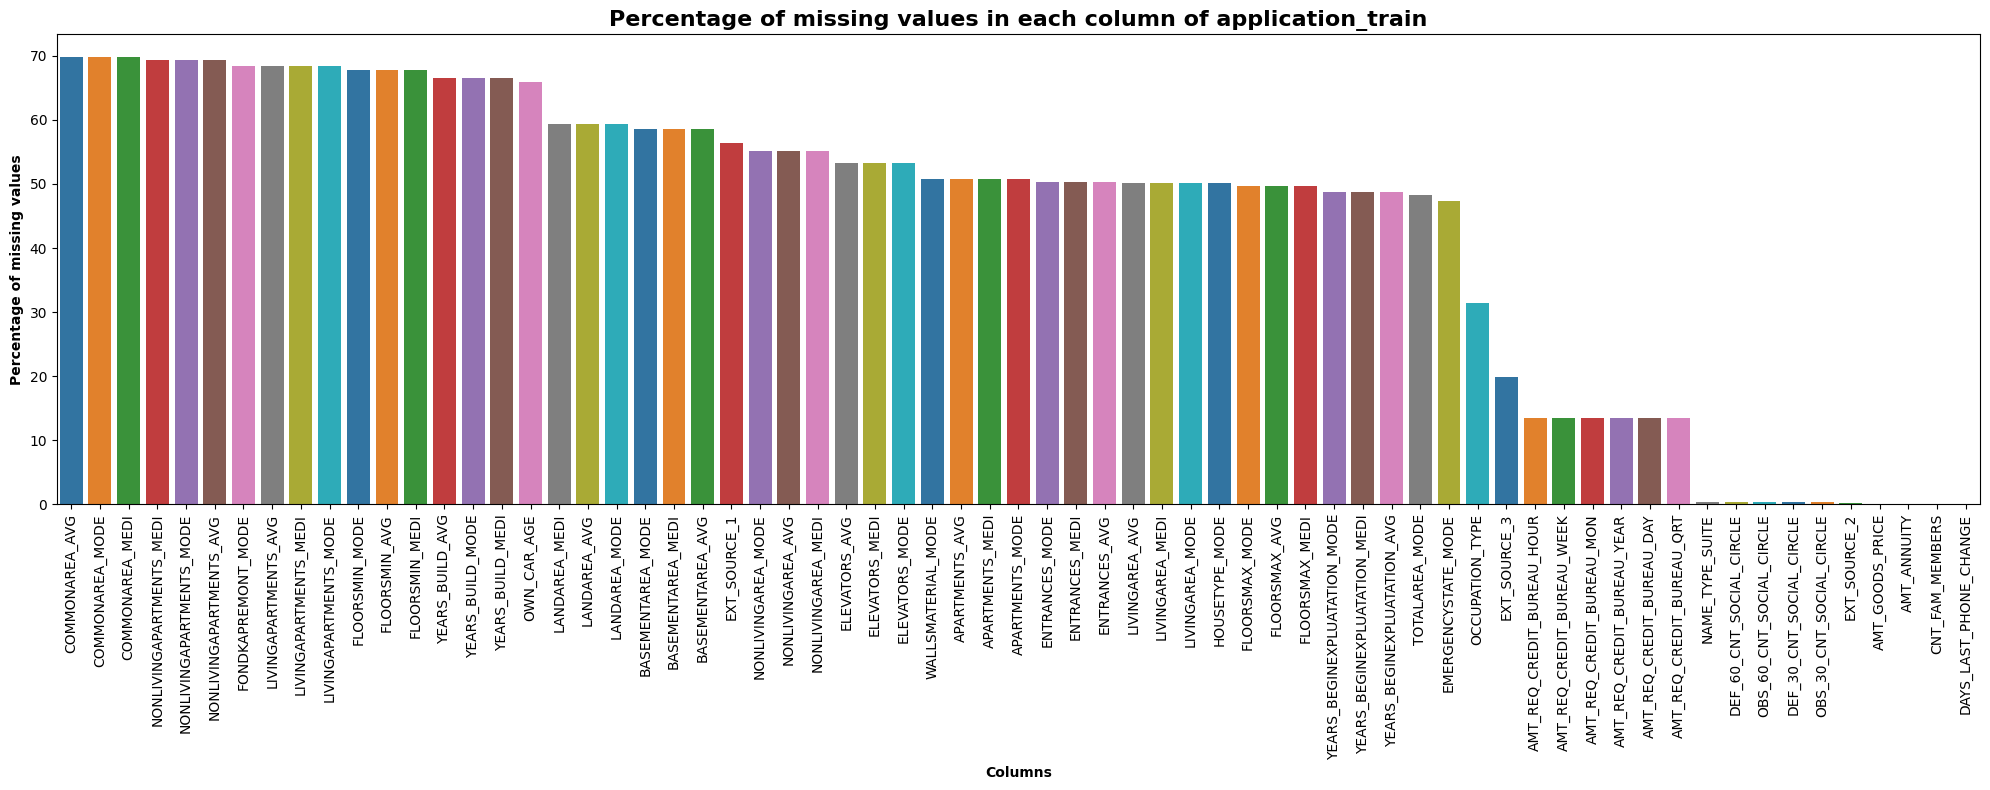

In [254]:
# Plot missing values in application_train
nan_df = nan_df_create(application_train)
plot_nan(nan_df, 'application_train', figsize=(20, 8), tight_layout=True)

### 4.2 Duplicates

In [255]:
# Check for duplicates in the entire dataset
duplicate_results = check_duplicates(application_train)
duplicate_mask = duplicate_results['duplicate_mask']
duplicate_df = duplicate_results['duplicate_df']
unique_df = duplicate_results['unique_df']
stats = duplicate_results['stats']

# Get the most commonly duplicated values
dup_counts = duplicate_results['dup_counts']

Total rows: 307511
Duplicate rows: 0 (0.00%)
Unique combinations: 307511
Number of duplicated combinations: 0


------------------------------------------
# - EDA bureau.csv

## 1. Shape and Description

In [256]:
print(f'Shape of bureau_merge: {bureau.shape}')
print('*' * 50)
print(f'Unique SK_ID_BUREAU in bureau: {bureau['SK_ID_BUREAU'].nunique()}')
print(f'Unique SK_ID_CURR in bureau: {bureau['SK_ID_CURR'].nunique()}')
print(f'Unique SK_ID_CURR of bureau in application_train: {application_train[application_train["SK_ID_CURR"].isin(bureau["SK_ID_CURR"])].shape[0]}')
print(f'Unique SK_ID_CURR of bureau in application_test: {application_test[application_test["SK_ID_CURR"].isin(bureau["SK_ID_CURR"])].shape[0]}') 
print('*' * 50)
print(f'Unique SK_ID_CURR in application_train: {application_train["SK_ID_CURR"].nunique()}')
print(f'Unique SK_ID_CURR in application_test: {application_test["SK_ID_CURR"].nunique()}')
print('*' * 50)
display(bureau.head())

Shape of bureau_merge: (1509345, 18)
**************************************************
Unique SK_ID_BUREAU in bureau: 1465325
Unique SK_ID_CURR in bureau: 307511
Unique SK_ID_CURR of bureau in application_train: 307511
Unique SK_ID_CURR of bureau in application_test: 0
**************************************************
Unique SK_ID_CURR in application_train: 307511
Unique SK_ID_CURR in application_test: 48744
**************************************************


,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


**Comments:**
- There are 263491 unique SK_ID_CURR in bureau
    + 210809 of that is in application_train, compare to the total 246009 of unique customer in app_train, it means some of them do not have loan history 
    + 52682 of that is in application_test, out of 61502 unique value

## 2. Univariate Analysis
- We will print out the histogram of all object columns to see their amount among each items
- We will do some descriptive statistic for the numeric columns to identify whether there is any logic problem

In [257]:
bureau_categorical_columns = bureau.select_dtypes(exclude=[np.number]).columns.tolist()
bureau_numerical_columns = bureau.select_dtypes(include=[np.number]).columns.tolist()

if 'SK_ID_BUREAU' in bureau_categorical_columns:
    bureau_categorical_columns.remove('SK_ID_BUREAU')
if 'SK_ID_BUREAU' in bureau_numerical_columns:
    bureau_numerical_columns.remove('SK_ID_BUREAU')
if 'SK_ID_CURR' in bureau_categorical_columns:
    bureau_categorical_columns.remove('SK_ID_CURR')
if 'SK_ID_CURR' in bureau_numerical_columns:
    bureau_numerical_columns.remove('SK_ID_CURR')

### 2.1 Categorical Variables

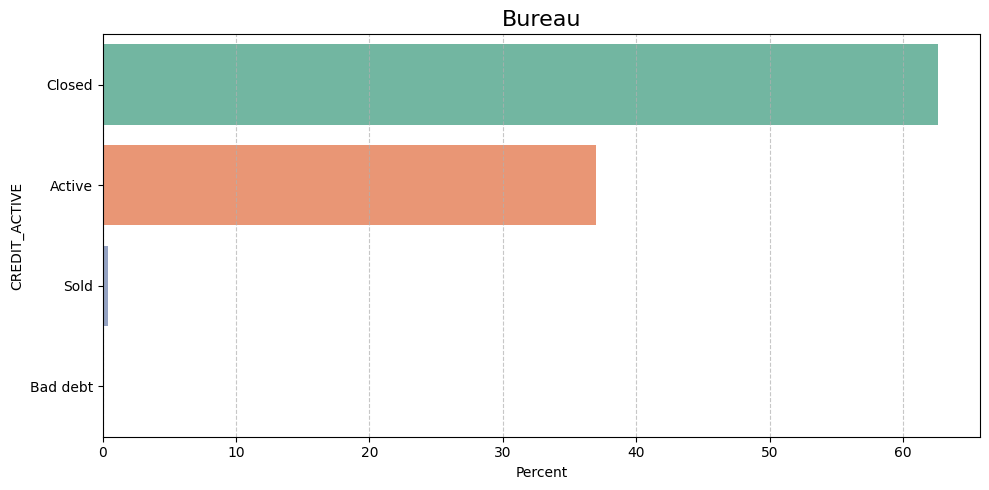

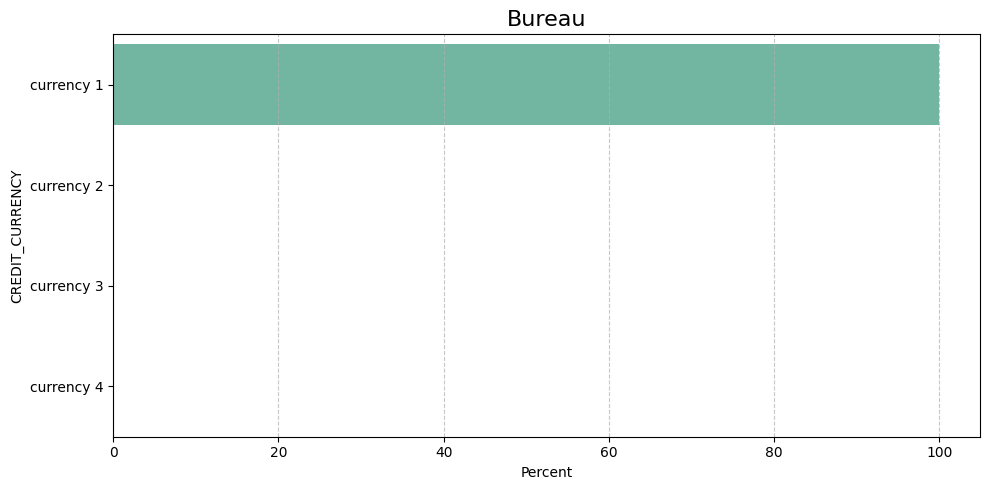

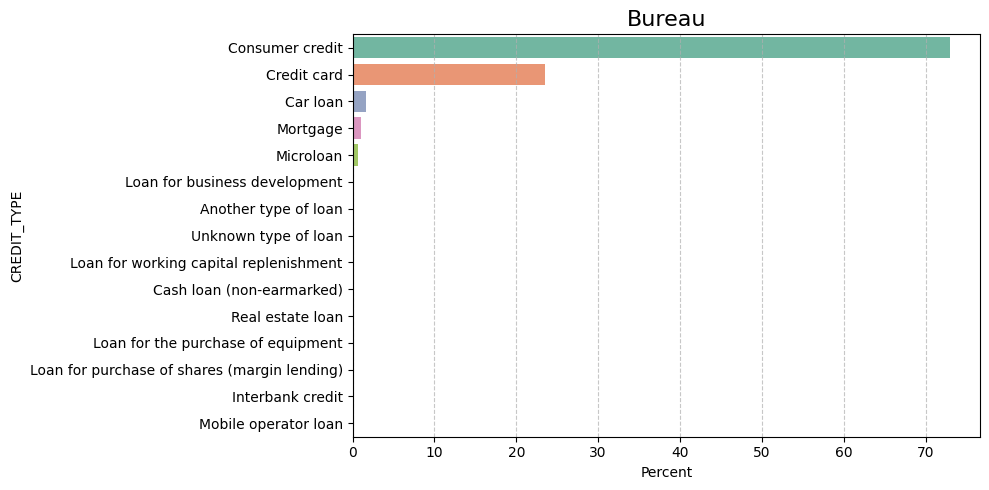

In [258]:
for col in bureau_categorical_columns:
    plot_object_col_percent(bureau, 'Bureau', col)

**Comment:**
- Most of the CREDIT_ACTIVE values are Closed (over 60%) and ACTIVE (about 35%), the rest are not much
- Almost all the value in CREDIT_CURRENCY is currency 1 -> Drop because it doesnt have much correlation with TARGET tbh
- The most popular type of credit is: Consumer Credit, Credit Card, Car loan and Mortgage, Microloan. For other value, I will grouped them into 1 categories name Others.

### 2.2 Numerical Variables

In [259]:
bureau.columns

Index(['SK_ID_CURR', 'TARGET', 'SK_ID_BUREAU', 'CREDIT_ACTIVE',
       'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype='object')

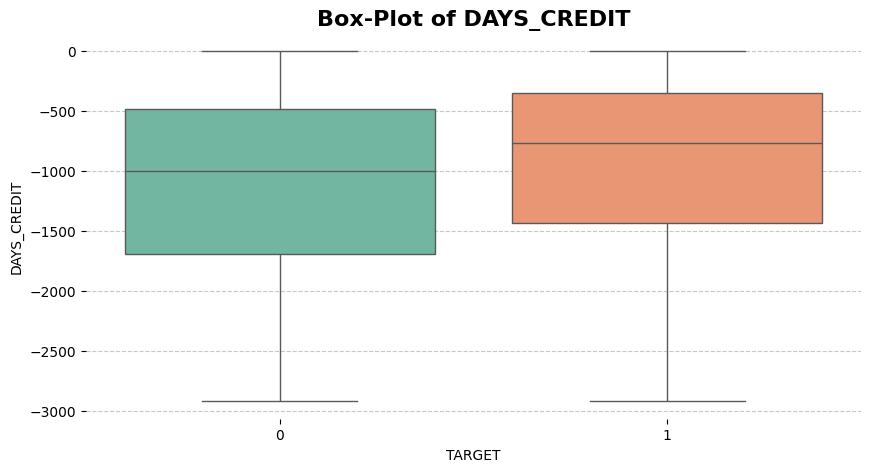

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT is -2922.0
The 25th percentile value of DAYS_CREDIT is -1671.0
The 50th percentile value of DAYS_CREDIT is -985.0
The 75th percentile value of DAYS_CREDIT is -470.0
The 90th percentile value of DAYS_CREDIT is -211.0
The 95th percentile value of DAYS_CREDIT is -122.0
The 99th percentile value of DAYS_CREDIT is -38.0
****************************************************************************************************


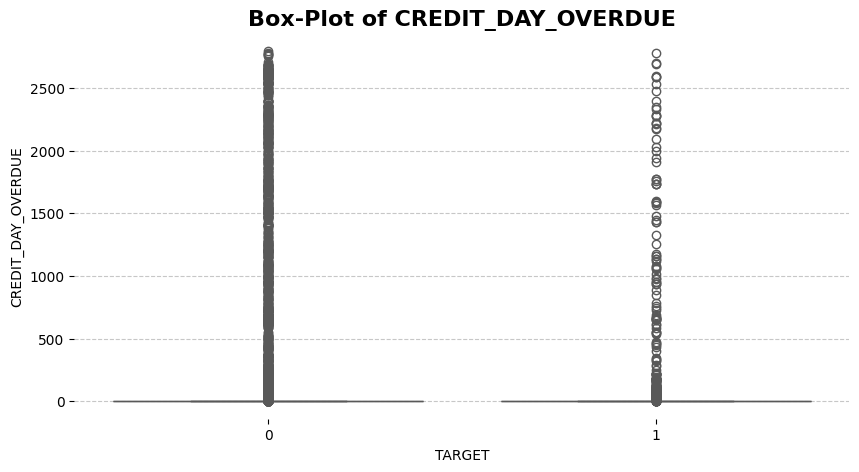

----------------------------------------------------------------------------------------------------
The 0th percentile value of CREDIT_DAY_OVERDUE is 0.0
The 25th percentile value of CREDIT_DAY_OVERDUE is 0.0
The 50th percentile value of CREDIT_DAY_OVERDUE is 0.0
The 75th percentile value of CREDIT_DAY_OVERDUE is 0.0
The 90th percentile value of CREDIT_DAY_OVERDUE is 0.0
The 95th percentile value of CREDIT_DAY_OVERDUE is 0.0
The 99th percentile value of CREDIT_DAY_OVERDUE is 0.0
****************************************************************************************************


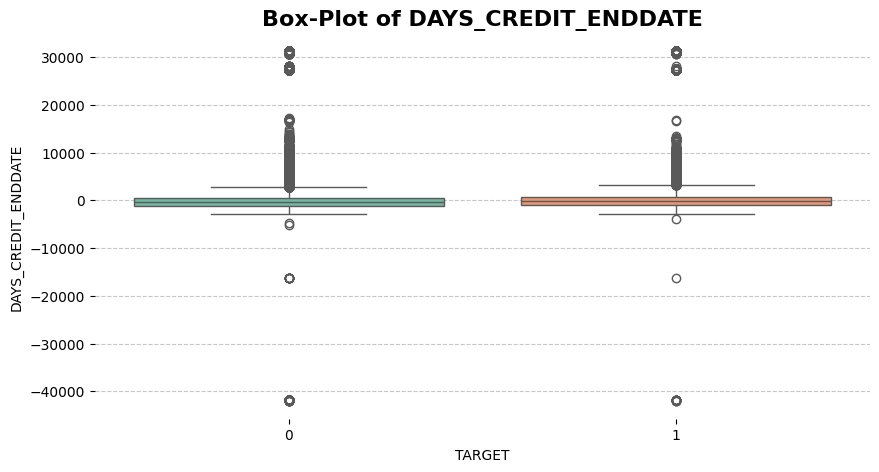

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 90th percentile value of DAYS_CREDIT_ENDDATE is 1332.0
The 95th percentile value of DAYS_CREDIT_ENDDATE is 2402.0
The 99th percentile value of DAYS_CREDIT_ENDDATE is 31062.0
****************************************************************************************************


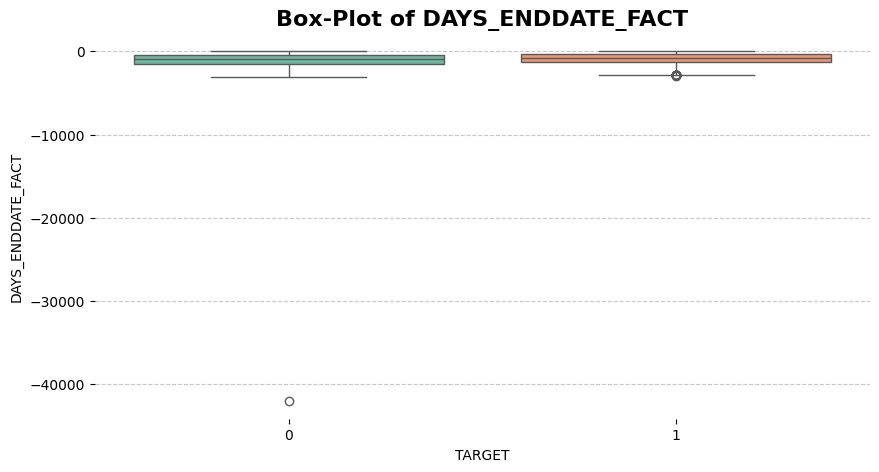

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 25th percentile value of DAYS_ENDDATE_FACT is -1503.0
The 50th percentile value of DAYS_ENDDATE_FACT is -900.0
The 75th percentile value of DAYS_ENDDATE_FACT is -427.0
The 90th percentile value of DAYS_ENDDATE_FACT is -177.0
The 95th percentile value of DAYS_ENDDATE_FACT is -94.0
The 99th percentile value of DAYS_ENDDATE_FACT is -24.0
****************************************************************************************************


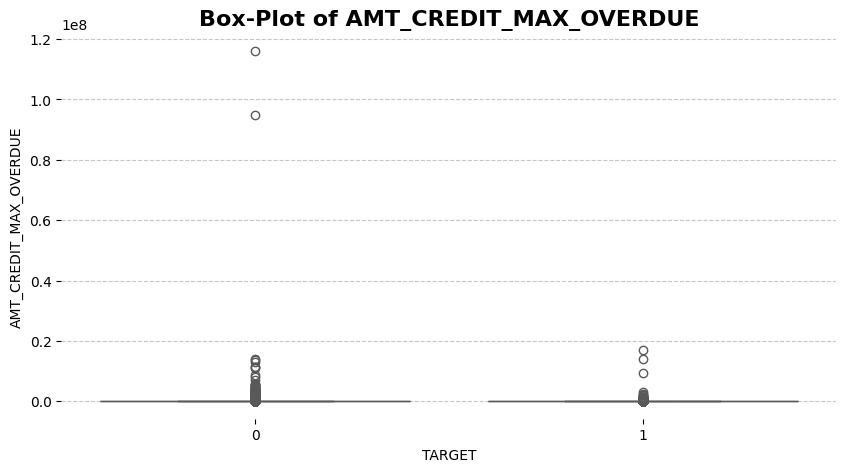

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_CREDIT_MAX_OVERDUE is 0.0
The 25th percentile value of AMT_CREDIT_MAX_OVERDUE is 0.0
The 50th percentile value of AMT_CREDIT_MAX_OVERDUE is 0.0
The 75th percentile value of AMT_CREDIT_MAX_OVERDUE is 0.0
The 90th percentile value of AMT_CREDIT_MAX_OVERDUE is 7632.517500000008
The 95th percentile value of AMT_CREDIT_MAX_OVERDUE is 14175.0
The 99th percentile value of AMT_CREDIT_MAX_OVERDUE is 41755.5
****************************************************************************************************


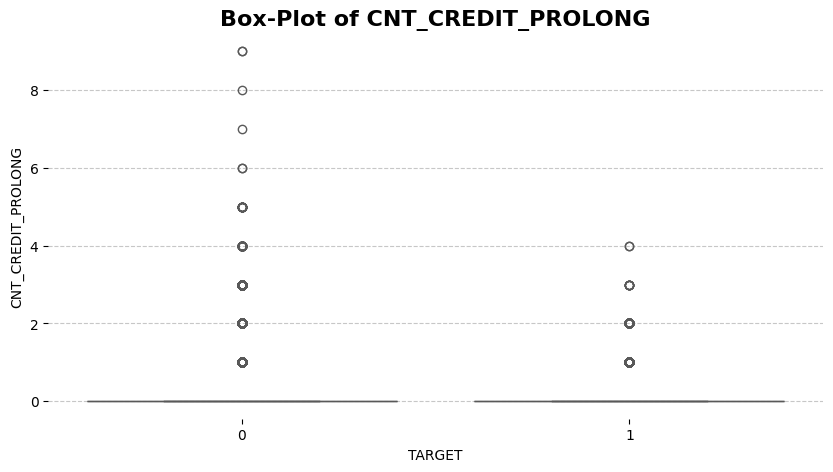

----------------------------------------------------------------------------------------------------
The 0th percentile value of CNT_CREDIT_PROLONG is 0.0
The 25th percentile value of CNT_CREDIT_PROLONG is 0.0
The 50th percentile value of CNT_CREDIT_PROLONG is 0.0
The 75th percentile value of CNT_CREDIT_PROLONG is 0.0
The 90th percentile value of CNT_CREDIT_PROLONG is 0.0
The 95th percentile value of CNT_CREDIT_PROLONG is 0.0
The 99th percentile value of CNT_CREDIT_PROLONG is 0.0
****************************************************************************************************


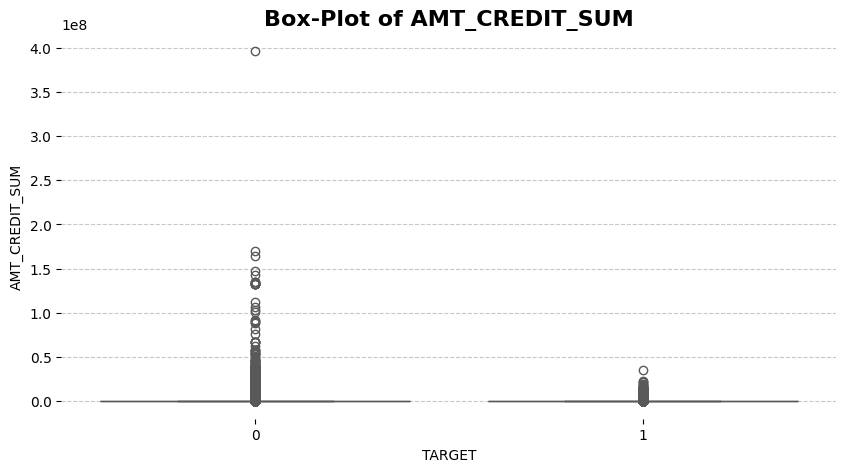

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_CREDIT_SUM is 0.0
The 25th percentile value of AMT_CREDIT_SUM is 51165.0
The 50th percentile value of AMT_CREDIT_SUM is 124698.1275
The 75th percentile value of AMT_CREDIT_SUM is 308250.0
The 90th percentile value of AMT_CREDIT_SUM is 765000.0
The 95th percentile value of AMT_CREDIT_SUM is 1350000.0
The 99th percentile value of AMT_CREDIT_SUM is 3600000.0
****************************************************************************************************


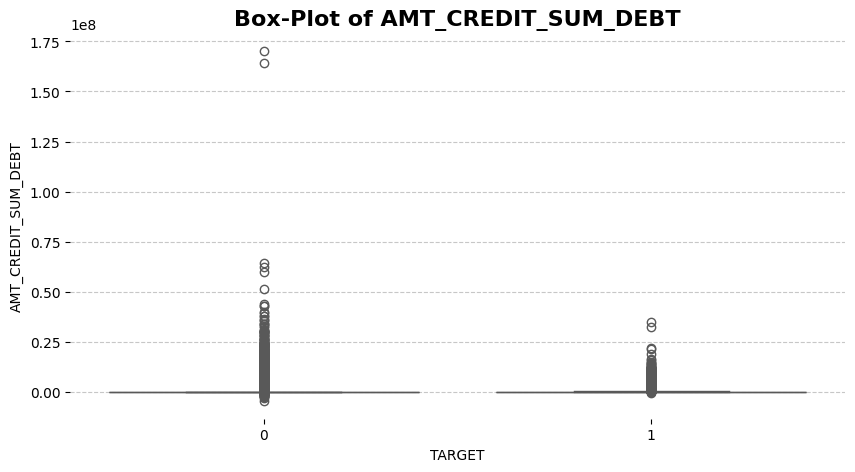

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_CREDIT_SUM_DEBT is -4705600.32
The 25th percentile value of AMT_CREDIT_SUM_DEBT is 0.0
The 50th percentile value of AMT_CREDIT_SUM_DEBT is 0.0
The 75th percentile value of AMT_CREDIT_SUM_DEBT is 39654.0
The 90th percentile value of AMT_CREDIT_SUM_DEBT is 291231.0
The 95th percentile value of AMT_CREDIT_SUM_DEBT is 623038.5
The 99th percentile value of AMT_CREDIT_SUM_DEBT is 2250000.0
****************************************************************************************************


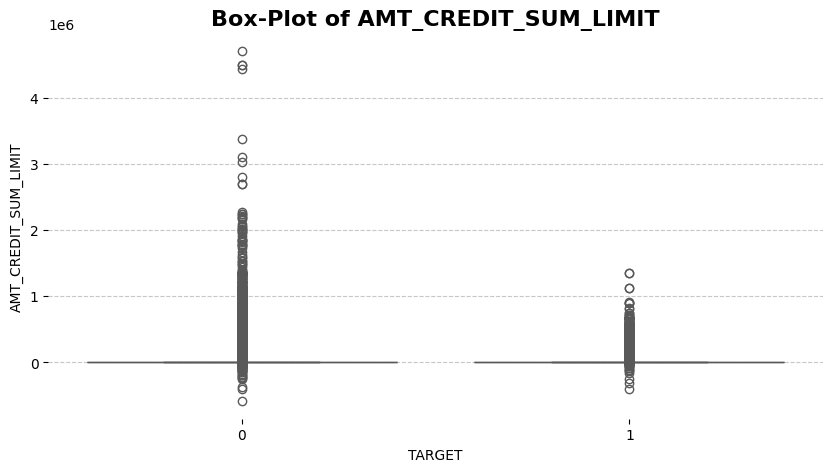

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_CREDIT_SUM_LIMIT is -586406.115
The 25th percentile value of AMT_CREDIT_SUM_LIMIT is 0.0
The 50th percentile value of AMT_CREDIT_SUM_LIMIT is 0.0
The 75th percentile value of AMT_CREDIT_SUM_LIMIT is 0.0
The 90th percentile value of AMT_CREDIT_SUM_LIMIT is 0.0
The 95th percentile value of AMT_CREDIT_SUM_LIMIT is 5862.932999999943
The 99th percentile value of AMT_CREDIT_SUM_LIMIT is 203109.6266999992
****************************************************************************************************


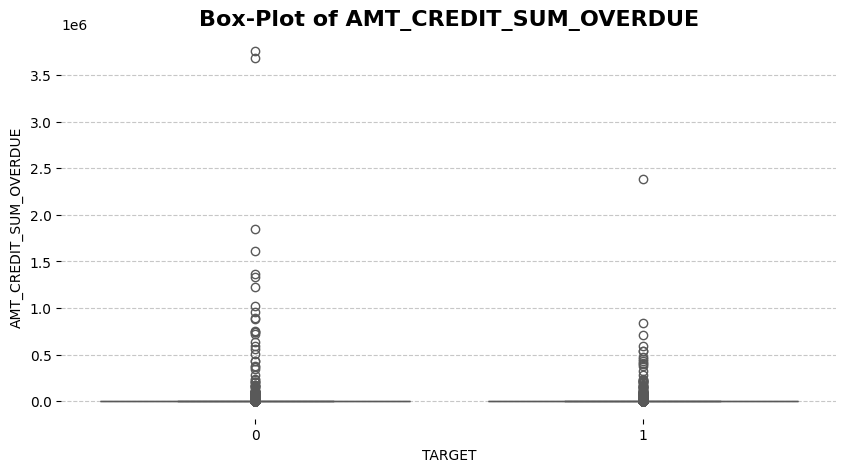

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
The 25th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
The 50th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
The 75th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
The 90th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
The 95th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
The 99th percentile value of AMT_CREDIT_SUM_OVERDUE is 0.0
****************************************************************************************************


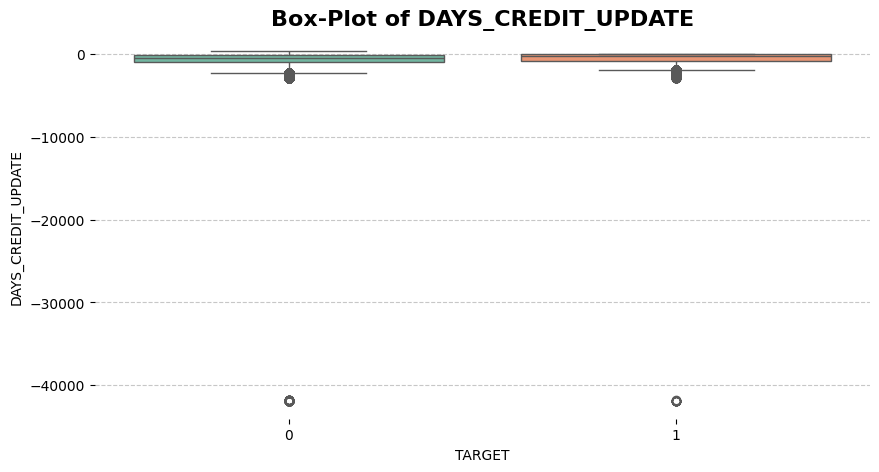

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 25th percentile value of DAYS_CREDIT_UPDATE is -904.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -406.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -33.0
The 90th percentile value of DAYS_CREDIT_UPDATE is -13.0
The 95th percentile value of DAYS_CREDIT_UPDATE is -8.0
The 99th percentile value of DAYS_CREDIT_UPDATE is -3.0
****************************************************************************************************


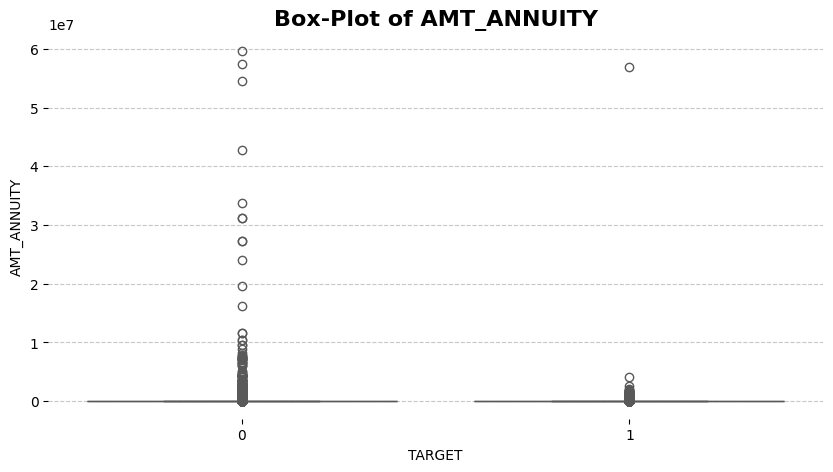

----------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_ANNUITY is 0.0
The 25th percentile value of AMT_ANNUITY is 0.0
The 50th percentile value of AMT_ANNUITY is 67.5
The 75th percentile value of AMT_ANNUITY is 13990.5
The 90th percentile value of AMT_ANNUITY is 31922.887500000026
The 95th percentile value of AMT_ANNUITY is 45931.5
The 99th percentile value of AMT_ANNUITY is 114889.5
****************************************************************************************************


In [260]:
# Exclude TARGET column from plots as it's already being used for comparison
plot_cols = [col for col in bureau_numerical_columns if col != 'TARGET']

# Loop through numerical columns to visualize
for col in plot_cols:
    try:
        # Check if there's enough valid data to plot
        if bureau[col].notna().sum() > 0:
            plot_continuous_variables(bureau, col, plot_types=['box'], log_scale=False)
            print_percentiles(bureau, col, percentiles=[0, 25, 50, 75, 90, 95, 99])
        else:
            print(f"Column {col} has no valid data to plot.")
    except Exception as e:
        print(f"Error plotting {col}: {str(e)}")
    

**Comment:**

1. **DAYS_CREDIT**: Số ngày kể từ khi khách hàng mở khoản vay tại tổ chức tín dụng (giá trị âm cho biết số ngày trước hiện tại).
    - Muộn nhất đã có khoản vay từ 8 năm trước
   
2. **CREDIT_DAY_OVERDUE**: Số ngày quá hạn thanh toán của khoản vay. Nếu bằng 0, khoản vay chưa quá hạn.
    - Đa số khoản vay ko quá hạn, tuy nhiên có khoản vay quá hạn đến hơn 3 năm

3. **DAYS_CREDIT_ENDDATE**: The remaining duration of the Credit Bureau credit (in days) at the time of the current application - Số ngày còn lại cho đến khi khoản vay kết thúc (tại thời điểm đơn vay hiện tại).
    - Có khoản tín dụng hết hạn từ 115 năm, có khoản tín dụng còn hiệu lực đến 80 năm ? -> Những giá trị này khả năng là lỗi -> Chuyển thành NaN, chỉ giữ lại những khoản trong vòng 8 năm đổ lại vì cột DAYS_CREDIT có giá trị thấp nhất là 8 năm trước, mà ngày hết hạn tín dụng lại trước cả ngày tín dụng có hiệu lực thì điều đó là vô lý.

4. **DAYS_ENDDATE_FACT**: The number of days since the Credit Bureau credit ended at the time of the current application (only for closed credits). Số ngày kể từ khi khoản vay thực tế kết thúc (chỉ áp dụng cho khoản vay đã đóng).
    - Again, kết thúc trước thời hạn 115 năm.

5. **AMT_CREDIT_MAX_OVERDUE**: Số tiền quá hạn tối đa từng ghi nhận cho khoản vay.
    - Đa số không có nợ quá hạn, tuy nhiên số ít lại có số nợ quá hạn quá lớn 115,987,185 (hàng trăm triệu), có thể cân nhắc thêm người này với bureau_balance trong thời gian đó (nếu có thể), nếu không cân nhắc để flag cho những người này do con số này có thể ảnh hưởng đến kq (nếu số người đủ lớn), còn không cân nhắc drop

6. **CNT_CREDIT_PROLONG**: Số lần khoản vay được gia hạn thêm.
    - Nhiều nhất 9 lần, ko đáng kể

7. **AMT_CREDIT_SUM**: Tổng số tiền tín dụng hiện tại (tổng hạn mức vay).
    - Đa số là không lớn, tuy nhiên có giá trị lên đến 396,000,000 -> cân nhắc (nếu hạn mức quá cao mà còn nợ nhiều thì khả năng có vấn đề)

8. **AMT_CREDIT_SUM_DEBT**: Tổng số dư nợ còn lại của khách hàng (tổng số tiền chưa trả).
    - Khoảng 1/2 là không còn dư nợ, tuy nhiên có những trường hợp rất lớn lên đến 170,100,000 -> cân nhắc đánh flag những khoản này

9. **AMT_CREDIT_SUM_LIMIT**: Hạn mức tín dụng còn lại mà khách hàng có thể sử dụng.
    - Tồn tại giá trị âm? Có thể là chi tiêu vượt hạn mức hoặc dữ liệu có vấn đề
    - Tồn tại giá trị 0? Có thể là khoản vay không có tín dụng quay vòng (có thể vì nhiều khoản vay trong credit type khác nhau)

10. **AMT_CREDIT_SUM_OVERDUE**: Tổng số tiền đang quá hạn thanh toán.
    - Đa số là không có

11. **DAYS_CREDIT_UPDATE**: the last update date relative to the loan application date.
    - Có người cập nhật lần cuối cách đây 115 năm ??? Vô lý
    - Again, số dương có nghĩa dữ liệu tín dụng sẽ được cập nhật sau 1 năm ??? Điều nay khá vô lý

12. **AMT_ANNUITY**: Số tiền khách hàng phải trả hàng năm cho khoản vay (khoản trả góp hàng năm).
    - Null nhiều nên chưa comment, tuy nhiên có những người ko bị yêu cầu phải trả hàng năm thì điêu


**Comment:**
- Thay những giá trị DAY_CREDIT_ENDDATE, DAY_ENDDATE_FACT, DAY_CREDIT_UPDATE thành NaN với những giá trị quá 50 năm, những giá trị này không mang nhiều ý nghĩa trong việc đánh giá khả năng tín dụng của khách hàng trong thời gian gần đây

In [261]:
#pd.set_option('display.max_rows', 153)
bureau.loc[(bureau['DAYS_CREDIT'] > bureau['DAYS_CREDIT_ENDDATE'])]

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
4982,101247,0,5181608.0,Closed,currency 1,-2445.0,0.0,-41819.0,-493.0,0.000,0.0,0.0,0.00,0.00,0.0,Credit card,-493.0,NaN
33963,108166,0,6600597.0,Active,currency 1,-644.0,0.0,-41853.0,NaN,0.000,0.0,115650.0,105031.08,10618.92,0.0,Credit card,-321.0,NaN
35446,108536,1,5071221.0,Active,currency 1,-2238.0,0.0,-41821.0,NaN,7057.890,0.0,130950.0,126410.58,4539.42,0.0,Credit card,-22.0,NaN
39146,109425,0,6555464.0,Closed,currency 1,-1482.0,0.0,-41873.0,-516.0,0.000,0.0,0.0,0.00,0.00,0.0,Credit card,-516.0,NaN
40687,109797,0,5181373.0,Closed,currency 1,-2664.0,0.0,-41819.0,-423.0,0.000,0.0,0.0,0.00,0.00,0.0,Credit card,-423.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438927,439811,1,6161704.0,Closed,currency 1,-2415.0,0.0,-42060.0,-781.0,39865.095,0.0,0.0,0.00,0.00,0.0,Credit card,-781.0,0.0
1460164,444757,0,5386952.0,Closed,currency 1,-2412.0,0.0,-41822.0,-673.0,0.000,0.0,0.0,0.00,0.00,0.0,Credit card,-673.0,NaN
1466360,446232,0,5896037.0,Closed,currency 1,-1999.0,0.0,-2001.0,-1989.0,NaN,0.0,1125000.0,0.00,NaN,0.0,Consumer credit,-1989.0,NaN
1477694,448911,0,5734016.0,Closed,currency 1,-2635.0,0.0,-41832.0,-2235.0,0.000,0.0,0.0,0.00,0.00,0.0,Credit card,-2235.0,NaN


**Comment:**
- Có một vài trường gặp tình trạng này, thường thì các giá trị DAYS_CREDIT_ENDDATE là siêu lớn so với DAYS_CREDIT, có 4 trường hợp đặc biệt là khoản vay đã được thanh toán và đúng là giá trị DAYS_ENDDATE_FACT > DAYS_CREDIT tuy nhiên giá trị DAYS_CREDIT_ENDDATE có vẻ bị điền giá trị sai
- DROP các trường DAYS_CREDIT_ENDDATE < DAYS_CREDIT

## 3. Bivariate Analysis

### 3.1. Numerical vs. Target

----------------------------------------------------------------------------------------------------


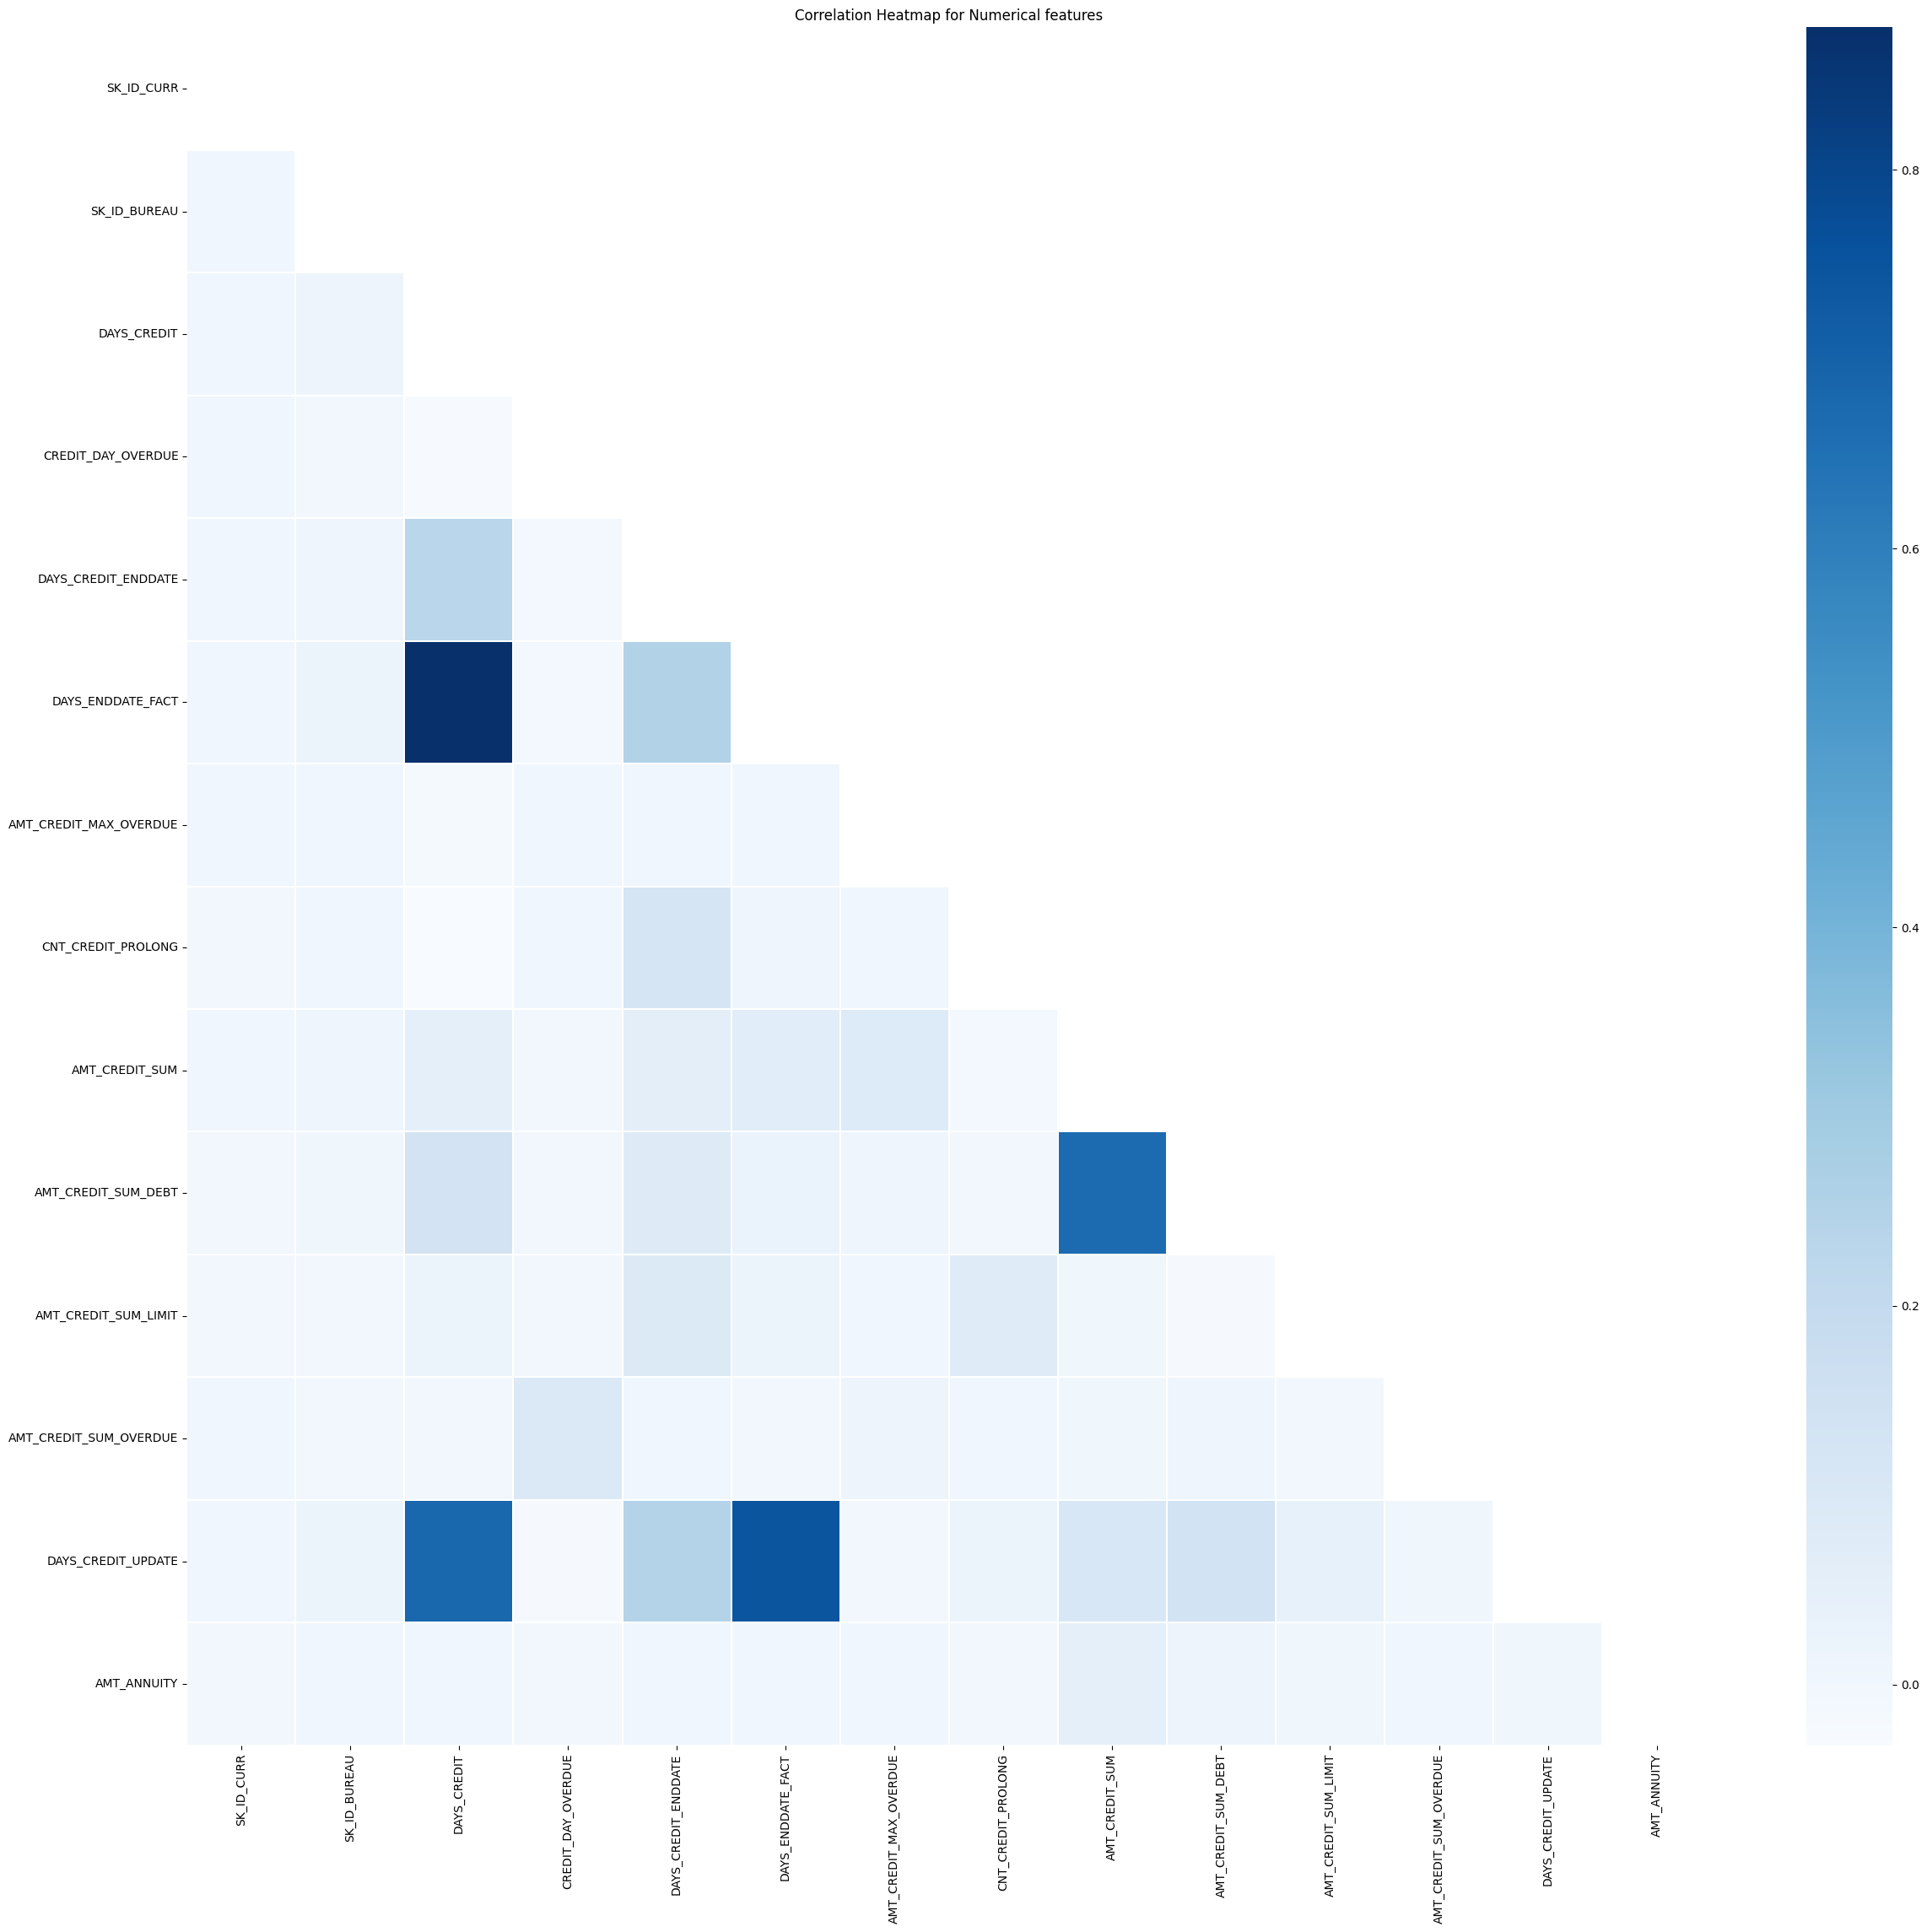

----------------------------------------------------------------------------------------------------


In [264]:
# Plot numerical and Target correlation
correlation = correlation_matrix(bureau, bureau_categorical_columns)
correlation.plot_correlation_matrix()

### 3.2. Categorical vs. Target

interval columns not set, guessing: ['TARGET']
****************************************************************************************************


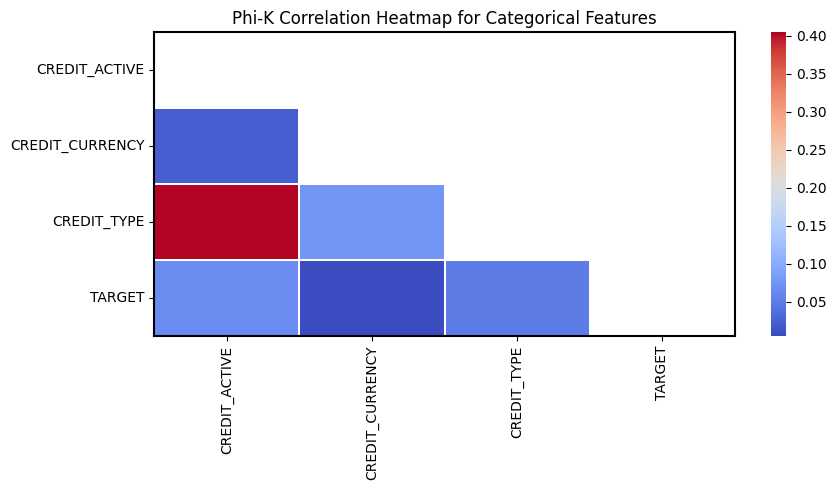

****************************************************************************************************
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
2,TARGET,1.000000
1,CREDIT_TYPE,0.049954
0,CREDIT_CURRENCY,0.004993


****************************************************************************************************


In [267]:
plot_phik_matrix(bureau, bureau_categorical_columns, figsize=(9, 5))

## 4. Data Quality

### 4.1. End Date too long


In [ ]:
bureau.loc[(bureau['DAYS_CREDIT_ENDDATE'] < -8.06*365)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
55561,324038,5233073,Active,currency 1,-841,0,-16322.0,NaN,0.00,0,0.0,264909.240,0.00,0.0,Credit card,-39,NaN
67507,147912,5007091,Active,currency 1,-388,0,-41847.0,NaN,0.00,0,225000.0,0.000,225000.00,0.0,Credit card,-241,NaN
98826,200629,6540711,Closed,currency 1,-2317,0,-41824.0,-428.0,8271.99,0,0.0,0.000,0.00,0.0,Credit card,-428,NaN
106353,120334,6585564,Closed,currency 1,-2579,0,-41836.0,-687.0,0.00,0,0.0,0.000,0.00,0.0,Credit card,-687,NaN
132479,149469,5225714,Active,currency 1,-2571,0,-41862.0,NaN,0.00,0,202500.0,172003.680,30496.32,0.0,Credit card,-212,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595661,437755,5596368,Active,currency 1,-2697,0,-16295.0,NaN,0.00,0,0.0,171183.600,0.00,0.0,Credit card,-12,NaN
1663955,141706,6649929,Closed,currency 1,-2783,0,-41823.0,-674.0,0.00,0,0.0,0.000,0.00,0.0,Credit card,-674,NaN
1667368,122988,5599599,Active,currency 1,-835,0,-16300.0,NaN,0.00,0,0.0,189031.725,0.00,0.0,Credit card,-17,NaN
1684396,293428,5571289,Closed,currency 1,-2252,0,-41846.0,-457.0,10323.36,0,0.0,0.000,0.00,0.0,Credit card,-457,NaN


**Comment:**
- tồn tại các khoản tín dụng đã hết từ cách đây hơn 100 năm ...
- (chỉ lấy khoản nợ có DAYS_CREDIT_ENDDATE trong 8 năm đổ lại) do gía trị quá lớn dẫn đến bất hợp lý. Có thể drop vì chỉ hơn 100 giá trị

In [ ]:
bureau.loc[(bureau['DAYS_CREDIT_ENDDATE'] > 50*365)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
141,444864,5714639,Closed,currency 1,-2030,0,31111.0,-1750.0,NaN,0,85050.0,0.00,0.00,0.0,Credit card,-555,NaN
180,286014,5714690,Active,currency 1,-137,0,27460.0,NaN,0.0,0,22500.0,18765.63,76.59,0.0,Credit card,-31,NaN
241,228777,5714776,Active,currency 1,-1144,0,31081.0,NaN,NaN,0,225000.0,0.00,0.00,0.0,Credit card,-41,NaN
393,221368,5714983,Active,currency 1,-64,0,27460.0,NaN,0.0,0,22500.0,0.00,22500.00,0.0,Credit card,-17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716322,392435,5055257,Active,currency 1,-151,0,31092.0,NaN,NaN,0,40500.0,32827.50,NaN,0.0,Credit card,-46,NaN
1716359,366785,5055579,Active,currency 1,-221,0,31090.0,NaN,NaN,0,45000.0,22941.00,NaN,0.0,Credit card,-221,NaN
1716379,250798,5057380,Active,currency 1,-471,0,31129.0,NaN,NaN,0,135000.0,6588.00,NaN,0.0,Credit card,-432,NaN
1716417,433007,5057703,Active,currency 1,-740,0,31128.0,NaN,NaN,0,67500.0,2466.00,NaN,0.0,Credit card,-433,NaN


**Comment:**
- Có rất nhiều khoản nợ vượt trên 8 năm, điều này không mang nhiều ý nghĩa đánh giá cho mô hình

In [ ]:
bureau.loc[(bureau['DAYS_ENDDATE_FACT'] < -8.06*365)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
198346,104463,6550986,Closed,currency 1,-2340,0,-1836.0,-42023.0,0.0,0,225000.0,0.0,225000.0,0.0,Credit card,-2196,NaN
1550542,394875,6638194,Closed,currency 1,-1021,0,74.0,-3042.0,NaN,0,711450.0,0.0,0.0,0.0,Consumer credit,-16,0.0


**Comment:**
- Có 2 khoản nợ được trả trước khi cả lúc nó được đăng ký -> Drop vì giá trị ko hợp lý

In [ ]:
bureau.loc[(bureau['DAYS_CREDIT_UPDATE'] < -8.05*365)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1943,219708,5716863,Closed,currency 1,-331,0,765.0,-208.0,0.0,0,16414.245,0.0,16414.245,0.0,Credit card,-41857,NaN
25051,448220,5200446,Closed,currency 1,-488,0,608.0,-457.0,0.0,0,72859.500,0.0,72859.500,0.0,Credit card,-41913,NaN
30474,380623,5800600,Active,currency 1,-281,0,815.0,NaN,0.0,0,225000.000,0.0,NaN,0.0,Credit card,-41906,NaN
30531,127624,5800677,Closed,currency 1,-364,0,732.0,-294.0,0.0,0,450000.000,0.0,450000.000,0.0,Credit card,-41886,NaN
60385,214335,5238926,Active,currency 1,-311,0,785.0,NaN,0.0,0,90000.000,0.0,NaN,0.0,Credit card,-41934,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655691,325600,6694071,Active,currency 1,-305,0,791.0,NaN,0.0,0,135000.000,0.0,NaN,0.0,Credit card,-41936,NaN
1664368,174528,6650455,Closed,currency 1,-265,0,831.0,-234.0,0.0,0,262619.640,0.0,262619.640,0.0,Credit card,-41854,NaN
1686166,442116,5573519,Closed,currency 1,-1224,0,-128.0,-1223.0,0.0,0,4500.000,0.0,4500.000,0.0,Credit card,-41884,NaN
1688873,136678,5576844,Closed,currency 1,-1048,0,48.0,-1022.0,0.0,0,135000.000,0.0,135000.000,0.0,Credit card,-41862,NaN


**Comment:**
- Các khoản nợ có thông tin về thời gian lần cuối được update nhỏ hơn cả khi nó được đăng ký cũng drop vì nó vô lý

In [ ]:
bureau.loc[(bureau['DAYS_CREDIT_UPDATE'] > 0)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
156979,282366,6595671,Active,currency 1,-484,0,1342.0,NaN,NaN,0,2555946.0,2140128.00,0.0,0.0,Car loan,20,NaN
272146,412793,5056780,Active,currency 1,-679,0,1147.0,NaN,NaN,0,3063946.5,2243178.00,0.0,0.0,Car loan,20,NaN
463222,323208,5977667,Active,currency 1,-241,0,1554.0,NaN,NaN,0,3755313.0,1658169.00,0.0,0.0,Car loan,13,NaN
471016,277653,5102523,Active,currency 1,-484,0,2073.0,NaN,NaN,0,3089313.0,2834914.50,0.0,0.0,Car loan,13,NaN
471246,306394,5102823,Active,currency 1,-268,0,828.0,NaN,NaN,0,2619000.0,2185474.50,0.0,0.0,Car loan,13,NaN
984063,315469,5074184,Active,currency 1,-594,0,1232.0,NaN,NaN,0,1125000.0,884875.50,0.0,0.0,Car loan,22,NaN
1099999,271171,5774840,Active,currency 1,-419,0,1042.0,NaN,NaN,0,2206138.5,1767573.00,0.0,0.0,Car loan,23,NaN
1111309,213638,6119857,Active,currency 1,-151,0,1675.0,NaN,NaN,0,2225641.5,2098674.00,0.0,0.0,Car loan,16,NaN
1171515,272467,6204245,Active,currency 1,-249,0,1942.0,NaN,NaN,0,5213277.0,5013787.50,0.0,0.0,Car loan,19,85500.0
1238331,243211,5917741,Active,currency 1,-360,0,2197.0,NaN,NaN,0,3360600.0,3205611.00,0.0,0.0,Car loan,14,NaN


- DAYS_CREDIT_UPDATE dương có nghĩa là trong x ngày tới, dữ liệu sẽ được updated? Tất cả các khoản vay có giá trị dương đều chưa hết hạn, và ENDDATE_FACT, ta giữ lại những khoản này

### 4.2. ENDDATE_FACT < 0 but CREDIT_ACTIVE = ACTIVE
- Vô lý vì khoản vay đã kết thúc từ trước nhưng vẫn đang tính hoạt động -> Chuyển CREDIT_ACTIVE sang Closed

In [ ]:
bureau.loc[(bureau['DAYS_ENDDATE_FACT'] < 0) &
           (bureau['CREDIT_ACTIVE'] == 'Active')]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1872,310981,5716773,Active,currency 1,-403,0,-188.0,-403.0,0.0,0,70487.190,0.0,0.0,0.0,Consumer credit,-403,NaN
5278,410992,5720807,Active,currency 1,-2575,0,-1472.0,-2411.0,0.0,0,0.000,0.0,0.0,0.0,Credit card,-627,NaN
7033,293616,5722940,Active,currency 1,-716,0,-198.0,-716.0,0.0,0,194364.000,0.0,0.0,0.0,Consumer credit,-715,NaN
7707,157937,5723780,Active,currency 1,-2475,0,-1364.0,-1276.0,0.0,0,45000.000,0.0,0.0,0.0,Credit card,-1168,NaN
7743,378672,5723823,Active,currency 1,-2718,0,-1608.0,-1276.0,0.0,0,180000.000,0.0,0.0,0.0,Credit card,-1165,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711721,110734,5090013,Active,currency 1,-60,0,-30.0,-44.0,0.0,0,22500.000,0.0,0.0,0.0,Consumer credit,-26,NaN
1711736,410645,5095999,Active,currency 1,-2685,0,-1559.0,-1349.0,0.0,0,225000.000,0.0,0.0,0.0,Credit card,-1225,NaN
1712703,398889,5077908,Active,currency 1,-1092,0,-696.0,-1092.0,0.0,0,140313.735,0.0,0.0,0.0,Consumer credit,-1092,NaN
1713185,199456,5085410,Active,currency 1,-2472,0,-1366.0,-2409.0,0.0,0,45000.000,0.0,0.0,0.0,Credit card,-646,NaN


--------------------------------
# - EDA bureau_balance.csv

## 1. Shape and Description

In [ ]:
print(f'Shape of bureau: {bureau.shape}')
print('*' * 50)
print(f'Unique SK_ID_BUREAU in bureau_balance: {bureau_balance['SK_ID_BUREAU'].nunique()}')
print(f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('*'*50)
display(bureau.head())

Shape of bureau: (1465325, 17)
**************************************************
Unique SK_ID_BUREAU in bureau_balance: 523515
Max number of months for Months Balance: 96
**************************************************


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14701612 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 448.7+ MB


In [ ]:
for col in bureau_balance.columns:
    if bureau_balance[col].dtype == 'object':
        print(f'Unique values in {col}: {bureau_balance[col].nunique()}')
        print(f'{bureau_balance[col].unique()}')

Unique values in STATUS: 8
['C' '0' 'X' '1' '2' '5' '4' '3']


**Comment:**
- C: closed
- X: no status
- 0: no DPD (Day Past Due)
- 1: 1-30 DPD
- 2: 30-60 DPD
- 3: 61-90 DPD
- 4: 91-120 DPD
- 5: 121+/ sold/ bad debt

- The status has been provided upto 8 years of history for loans of those exist

## 2. Data Quality

In [ ]:
plot_nan(nan_df_create(bureau_balance), 'bureau_balance')

No missing values in the dataframe
